In [1]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras


import numpy as np

In [2]:
# load the dataset
dataset = np.loadtxt('files/pima-indians-diabetes.csv', delimiter=',', skiprows=1)
# 1st row is header
dataset

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [3]:
X = dataset[:,0:8]
y = dataset[:,8]

In [4]:
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [5]:
len(y)

768

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In Keras, there are two ways to create a model, the `Sequential model` and the `Functional API`.

* The `Sequential model` is a bit more intuitive in the sense that it considers a neural network as a stack of layers where each layer has exactly one input tensor and one output tensor, which is the usual way a neural work is presented;
* `Function API` is more flexible than `Sequential model` because it can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

Although `Sequential model` should be enough for this project, for the sake of accommodating possible future needs, `Functional API` approach is used.

In [7]:
visible = Input(shape=(8,))
hidden = Dense(100, activation='relu')(visible)
output = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=visible, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 100)               900       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


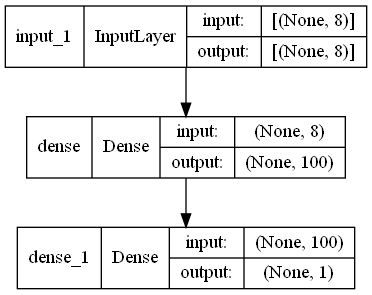

In [8]:
keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
52/52 [==============================] - 1s 3ms/step - loss: 2.1341 - accuracy: 0.5895
Epoch 2/50
52/52 [==============================] - 0s 3ms/step - loss: 0.9580 - accuracy: 0.6128
Epoch 3/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7938 - accuracy: 0.6031
Epoch 4/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7828 - accuracy: 0.6167
Epoch 5/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7042 - accuracy: 0.6770
Epoch 6/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7252 - accuracy: 0.6420
Epoch 7/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.6634
Epoch 8/50
52/52 [==============================] - 0s 3ms/step - loss: 0.7657 - accuracy: 0.6381
Epoch 9/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6902 - accuracy: 0.6459
Epoch 10/50
52/52 [==============================] - 0s 3ms/step - loss: 0.6030 - accuracy: 0.6984
Epoch 11/50
52/52 [

Confusion matrix:
[[257  75]
 [ 47 135]]


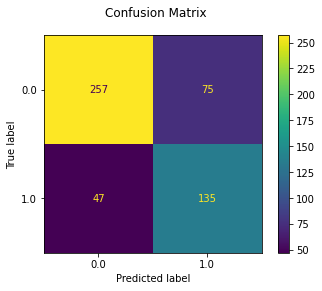

In [11]:
y_pred = (model.predict(X_train) > 0.5).astype(int)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_train, y_pred=y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

Confusion matrix:
[[123  45]
 [ 32  54]]
Balanced accuracy: 68.00%


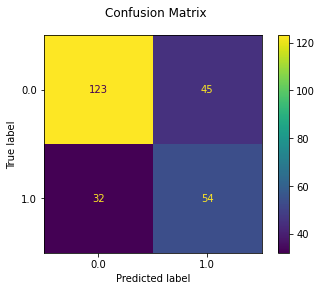

In [12]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
accuracy = (tn + tp) / (tn + fp + fn + tp)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
balanced_accuracy = (tpr + tnr) / 2
print(f"Balanced accuracy: {balanced_accuracy*100:.2f}%")

In [13]:
from sklearn.neural_network import MLPClassifier as mlpc

clf = mlpc(hidden_layer_sizes=(100, ))
# Keras allows users to specify the activation function of the output layer.
# However, you canNOT set this parameter in scikit-learn, though you can check
# the automatically selected activation function via the out_activation_ attribute of
# a model.
# https://stackoverflow.com/questions/55337843/what-kind-of-activation-is-used-by-scikitlearns-mlpclasssifier-in-output-layer
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Confusion matrix:
[[145  23]
 [ 42  44]]


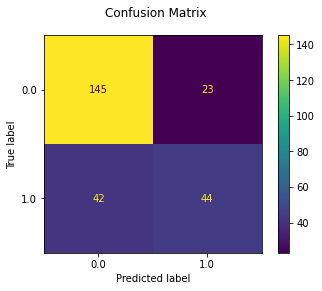

In [14]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

In [15]:
tn, fp, fn, tp = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
accuracy = (tn + tp) / (tn + fp + fn + tp)
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tnr = tn / (tn + fp)
balanced_accuracy = (tpr + tnr) / 2
print(f"Balanced accuracy: {balanced_accuracy*100:.2f}%")

Balanced accuracy: 68.74%
